In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option("display.max_columns", 200)
import warnings
warnings.filterwarnings('ignore')

## Read datasets from CSV

In [3]:
df = pd.read_csv("../1. [A]ttack dataset/2. Internet/attack_dataset.csv.gz") # attack dataset
bonafide = pd.read_csv('../2. [B]onafide dataset/data/bonafide_dataset_20191121.csv.gz') # bonafide traffic from mawilab
bonafide = pd.concat([bonafide, pd.read_csv('../2. [B]onafide dataset/data/bonafide_dataset_20201110.csv.gz')])
bonafide = pd.concat([bonafide, pd.read_csv('../2. [B]onafide dataset/data/bonafide_dataset_20201129.csv.gz')])
print(df.shape, bonafide.shape)

(455503, 42) (380438, 41)


In [4]:
bonafide['label'] = "bonafide" # label column in the bonafide dataset

## Comparison of datasets
> Check if both datasets have the same columns and calculate the % of attacks vs. normal traffic

In [5]:
if (df.columns == bonafide.columns).all():
    examples_malicious = df.shape[0]
    examples_legitim = bonafide.shape[0]
    total = examples_malicious+examples_legitim
    print('Total examples of {0} with {1:0.2f} of attack and {2:0.2f} bonafide packets'.format(total, examples_malicious/total, examples_legitim/total))

Total examples of 835941 with 0.54 of attack and 0.46 bonafide packets


In [6]:
df.head()

,frame_info.encap_type,frame_info.time,frame_info.time_epoch,frame_info.number,frame_info.len,frame_info.cap_len,eth.type,ip.version,ip.hdr_len,ip.tos,ip.id,ip.flags,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.proto,ip.checksum,ip.src,ip.dst,ip.len,ip.dsfield,tcp.srcport,tcp.dstport,tcp.seq,tcp.ack,tcp.len,tcp.hdr_len,tcp.flags,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val,label
0,1,"Sep 2, 2020 21:04:37.063530000 -03",1.599091e+09,1,74,74,0x00000800,4,20,NaN,0x00001b58,0x00000000,0,0,0,0,35,6,0x00003e78,179.241.213.24,172.26.8.200,60,0x00000000,1697,5802,0,0,0,40,0x00000002,0,1,0,0,0,0,0,64240,0x0000c9e9,0,1410.0,nmap_null
1,1,"Sep 2, 2020 21:04:39.363792000 -03",1.599091e+09,2,74,74,0x00000800,4,20,NaN,0x000098f1,0x00000000,0,0,0,0,33,6,0x0000c2de,179.241.213.24,172.26.8.200,60,0x00000000,1722,5060,0,0,0,40,0x00000002,0,1,0,0,0,0,0,64240,0x000090cb,0,1410.0,nmap_null
2,1,"Nov 16, 2020 18:15:14.851050000 -03",1.605561e+09,1,54,54,0x00000800,4,20,NaN,0x00007d48,0x00000000,0,0,0,0,37,6,0x0000ff86,34.227.65.60,172.26.8.200,40,0x00000000,44952,443,1,1,0,20,0x00000010,0,0,0,0,1,0,0,1024,0x00005bc3,0,NaN,nmap_window
3,1,"Nov 16, 2020 18:15:14.851566000 -03",1.605561e+09,2,54,54,0x00000800,4,20,NaN,0x000072bd,0x00000000,0,0,0,0,28,6,0x00001312,34.227.65.60,172.26.8.200,40,0x00000000,44952,1025,1,1,0,20,0x00000010,0,0,0,0,1,0,0,1024,0x0000597d,0,NaN,nmap_window
4,1,"Nov 16, 2020 18:15:14.851753000 -03",1.605561e+09,3,54,54,0x00000800,4,20,NaN,0x0000b39a,0x00000000,0,0,0,0,31,6,0x0000cf34,34.227.65.60,172.26.8.200,40,0x00000000,44952,111,1,1,0,20,0x00000010,0,0,0,0,1,0,0,1024,0x00005d0f,0,NaN,nmap_window


In [7]:
df.label.value_counts()

zmap             74613
nmap_connect     45882
hping_syn        43750
unicorn_syn      43039
nmap_syn         40642
unicorn_conn     39170
masscan          21138
nmap_ack         20497
nmap_window      18851
nmap_null        12511
nmap_xmas        12505
nmap_fin         12504
hping_ack        11344
nmap_maimon      10493
unicorn_ack       8494
hping_null        7344
hping_xmas        7344
hping_fin         7344
unicorn_null      4690
unicorn_xmas      4466
unicorn_fxmas     4444
unicorn_fin       4438
Name: label, dtype: int64

---
## Pre-processing
> It is required to convert features that are extracted from `pcap` as hexadecimal

> Replaced the fields with null values (NaN) by zero

In [8]:
fields = ['eth.type', 'ip.id', 'ip.flags', 'ip.checksum', 'ip.dsfield', 'tcp.flags', 'tcp.checksum']

for field in fields:
    df[field] = df[field].apply(lambda x: int(str(x), 16))
    

In [9]:
bonafide = bonafide.fillna(0)
for field in fields:
    bonafide[field] = bonafide[field].apply(lambda x: int(str(x), 16))

### Create a dataset with all packets (normal and malicious)

In [10]:
full_data = pd.concat([bonafide, df])

### Check if there are packets with protocol field different than TCP (value 6)

In [11]:
wrong_proto = full_data[full_data['ip.proto'] != 6]['label'].value_counts().values
full_data = full_data[full_data['ip.proto'] == 6]
print("Found and removed", wrong_proto,"packets from the original dataset.")

Found and removed [52177] packets from the original dataset.


In [12]:
full_data.label.value_counts()

bonafide         328261
zmap              74613
nmap_connect      45882
hping_syn         43750
unicorn_syn       43039
nmap_syn          40642
unicorn_conn      39170
masscan           21138
nmap_ack          20497
nmap_window       18851
nmap_null         12511
nmap_xmas         12505
nmap_fin          12504
hping_ack         11344
nmap_maimon       10493
unicorn_ack        8494
hping_null         7344
hping_xmas         7344
hping_fin          7344
unicorn_null       4690
unicorn_xmas       4466
unicorn_fxmas      4444
unicorn_fin        4438
Name: label, dtype: int64

### Features not applicable to this work

> Remove features from layer 2 (link):
> - frame_info.time
> - frame_info.encap_type
> - frame_info.time_epoch
> - frame_info.number
> - frame_info.len
> - frame_info.cap_len
> - eth.type

> Remove redundant features or non-variant (constant)
> - ip.version - we are considering only IPv4
> - ip.proto - we are considering only TCP
> - ip.src
> - ip.dst
> - ip.flags
> - tcp.flags

In [13]:
full_data.drop(columns=['frame_info.time', 'frame_info.encap_type', 'frame_info.time_epoch', 'frame_info.number', 
                        'frame_info.len', 'frame_info.cap_len', 'eth.type', 'ip.flags', 'ip.src', 'ip.dst',
                        'ip.version', 'ip.proto', 'tcp.flags'], axis=1, inplace=True)

## Exploratory Data Analysis

In [14]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783764 entries, 1 to 455502
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ip.hdr_len           783764 non-null  float64
 1   ip.tos               328261 non-null  float64
 2   ip.id                783764 non-null  int64  
 3   ip.flags.rb          783764 non-null  float64
 4   ip.flags.df          783764 non-null  float64
 5   ip.flags.mf          783764 non-null  float64
 6   ip.frag_offset       783764 non-null  float64
 7   ip.ttl               783764 non-null  float64
 8   ip.checksum          783764 non-null  int64  
 9   ip.len               783764 non-null  float64
 10  ip.dsfield           783764 non-null  int64  
 11  tcp.srcport          783764 non-null  float64
 12  tcp.dstport          783764 non-null  float64
 13  tcp.seq              783764 non-null  float64
 14  tcp.ack              783764 non-null  float64
 15  tcp.len          

In [15]:
full_data.describe()

,ip.hdr_len,ip.tos,ip.id,ip.flags.rb,ip.flags.df,ip.flags.mf,ip.frag_offset,ip.ttl,ip.checksum,ip.len,ip.dsfield,tcp.srcport,tcp.dstport,tcp.seq,tcp.ack,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.checksum,tcp.urgent_pointer,tcp.options.mss_val
count,783764.0,328261.0,783764.000000,783764.0,783764.000000,783764.000000,783764.0,783764.000000,783764.000000,783764.000000,783764.00000,783764.000000,783764.000000,7.837640e+05,7.837640e+05,783764.000000,783764.000000,783764.000000,783764.000000,783764.000000,783764.000000,783764.000000,783764.000000,783764.000000,7.837640e+05,783764.000000,783764.000000,592683.000000
mean,20.0,0.0,30203.740695,0.0,0.645392,0.000003,0.0,79.569486,32781.104567,180.276429,3.13223,37586.192331,10915.703462,8.771130e+06,2.909447e+07,130.525147,29.747587,0.082888,0.552572,0.052349,0.065710,0.368189,0.014041,0.005017,3.169473e+04,32746.173250,0.543726,737.523715
std,0.0,0.0,20375.832825,0.0,0.478395,0.001597,0.0,78.305417,18708.633422,411.303561,9.68393,20682.776858,18710.648524,1.011235e+08,2.150445e+08,411.599412,9.062705,0.275714,0.497229,0.222729,0.247774,0.482313,0.117661,0.070652,7.277133e+04,18994.536957,158.847216,721.799498
min,20.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,40.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,20.0,0.0,11779.000000,0.0,0.000000,0.000000,0.0,34.000000,17178.000000,40.000000,0.00000,19750.000000,80.000000,0.000000e+00,0.000000e+00,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.024000e+03,16309.000000,0.000000,0.000000
50%,20.0,0.0,29827.000000,0.0,1.000000,0.000000,0.0,41.000000,32137.000000,52.000000,0.00000,43990.000000,892.000000,0.000000e+00,0.000000e+00,0.000000,32.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.638400e+04,32605.500000,0.000000,1240.000000
75%,20.0,0.0,48693.000000,0.0,1.000000,0.000000,0.0,61.000000,49056.000000,60.000000,0.00000,53704.000000,9101.000000,1.000000e+00,1.000000e+00,0.000000,40.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,6.424000e+04,49283.000000,0.000000,1440.000000
max,20.0,0.0,65535.000000,0.0,1.000000,1.000000,0.0,254.000000,65534.000000,8289.000000,224.00000,65534.000000,65535.000000,4.294967e+09,4.294967e+09,8237.000000,60.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.677696e+07,65534.000000,64447.000000,9176.000000


In [16]:
# check features with zero variance, they do not support the learning task
(full_data.var() == 0)

ip.hdr_len              True
ip.tos                  True
ip.id                  False
ip.flags.rb             True
ip.flags.df            False
ip.flags.mf            False
ip.frag_offset          True
ip.ttl                 False
ip.checksum            False
ip.len                 False
ip.dsfield             False
tcp.srcport            False
tcp.dstport            False
tcp.seq                False
tcp.ack                False
tcp.len                False
tcp.hdr_len            False
tcp.flags.fin          False
tcp.flags.syn          False
tcp.flags.reset        False
tcp.flags.push         False
tcp.flags.ack          False
tcp.flags.urg          False
tcp.flags.cwr          False
tcp.window_size        False
tcp.checksum           False
tcp.urgent_pointer     False
tcp.options.mss_val    False
dtype: bool

### Remove columns with variance zero

In [17]:
full_data.drop(columns=['ip.hdr_len', 'ip.tos', 'ip.flags.rb', 
                        'ip.flags.mf', 'ip.frag_offset'], axis=1, inplace=True)

### Univariate features analysis (boxplot)

In [18]:
full_data.columns

Index(['ip.id', 'ip.flags.df', 'ip.ttl', 'ip.checksum', 'ip.len', 'ip.dsfield',
       'tcp.srcport', 'tcp.dstport', 'tcp.seq', 'tcp.ack', 'tcp.len',
       'tcp.hdr_len', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.ack', 'tcp.flags.urg', 'tcp.flags.cwr',
       'tcp.window_size', 'tcp.checksum', 'tcp.urgent_pointer',
       'tcp.options.mss_val', 'label'],
      dtype='object')

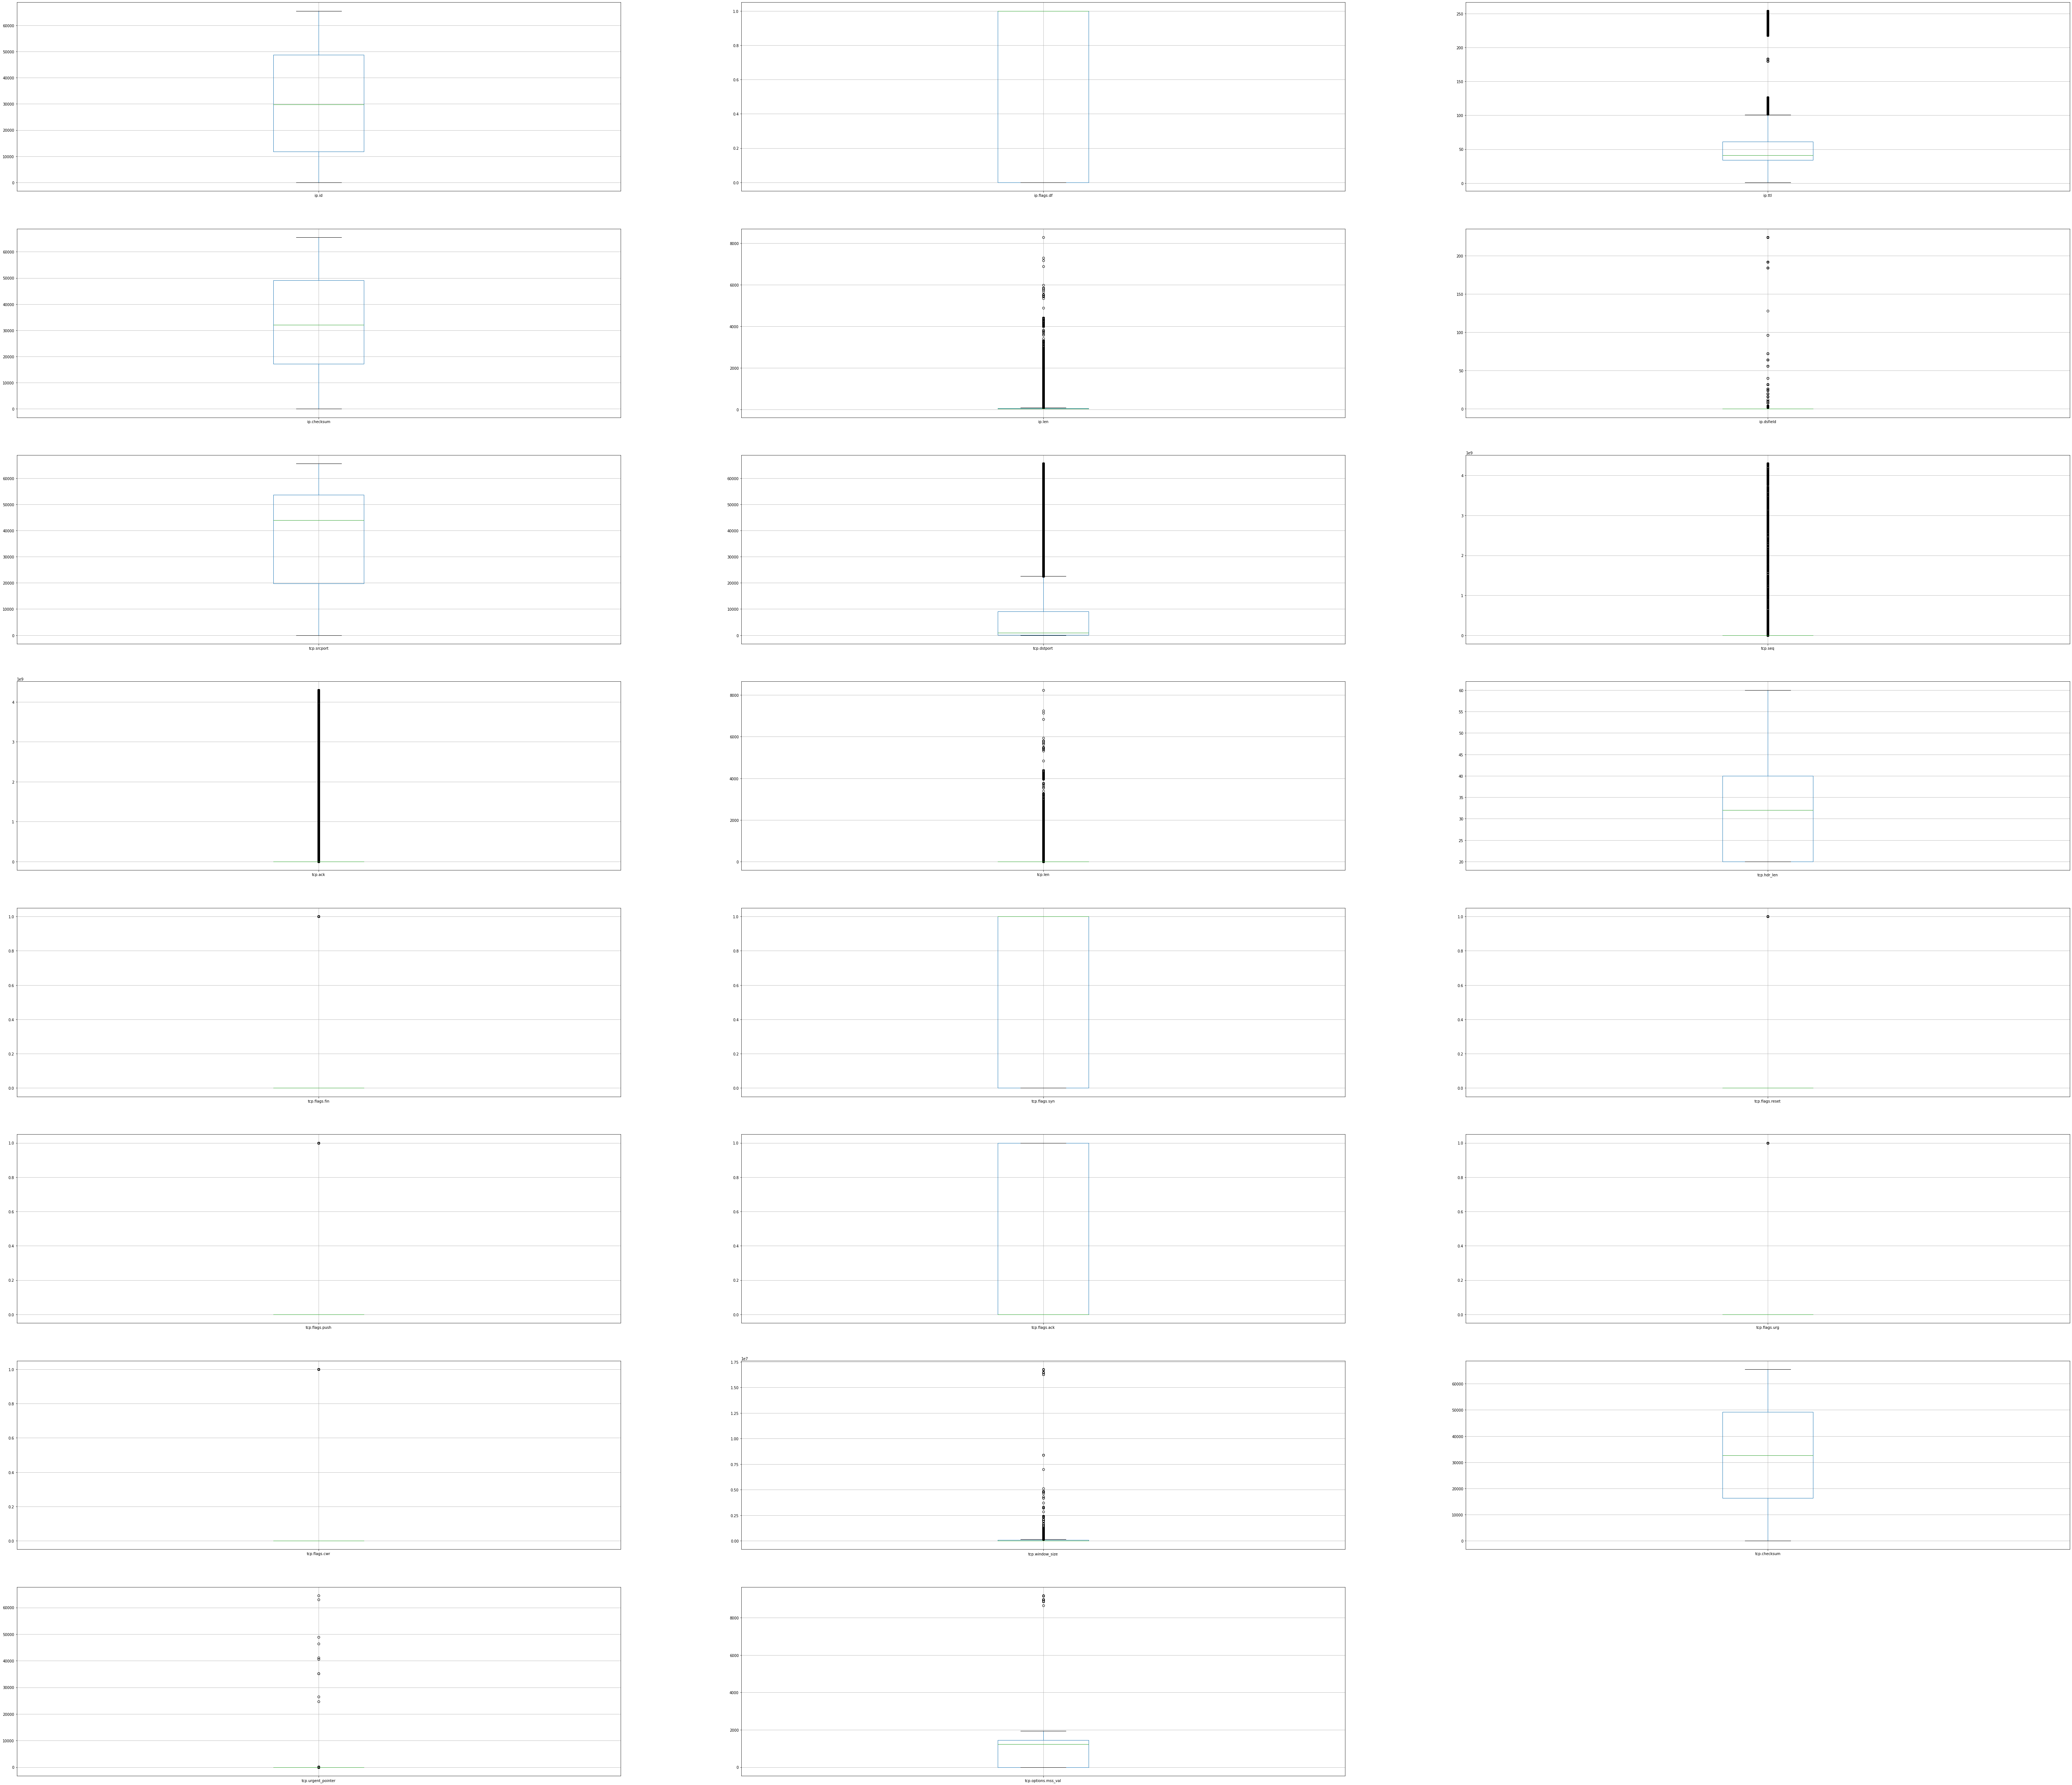

In [19]:
colunas = 3
linhas = int(full_data.shape[1]/colunas)+1

plt.figure(figsize = [100, 100])

i = 1
for column in full_data.columns.values:
    if column != "label":
        plt.subplot(linhas, colunas, i)
        full_data.boxplot([column]);
        i += 1

### Bivariate Anaysis - Linear Correlation (threshold greater than 0)

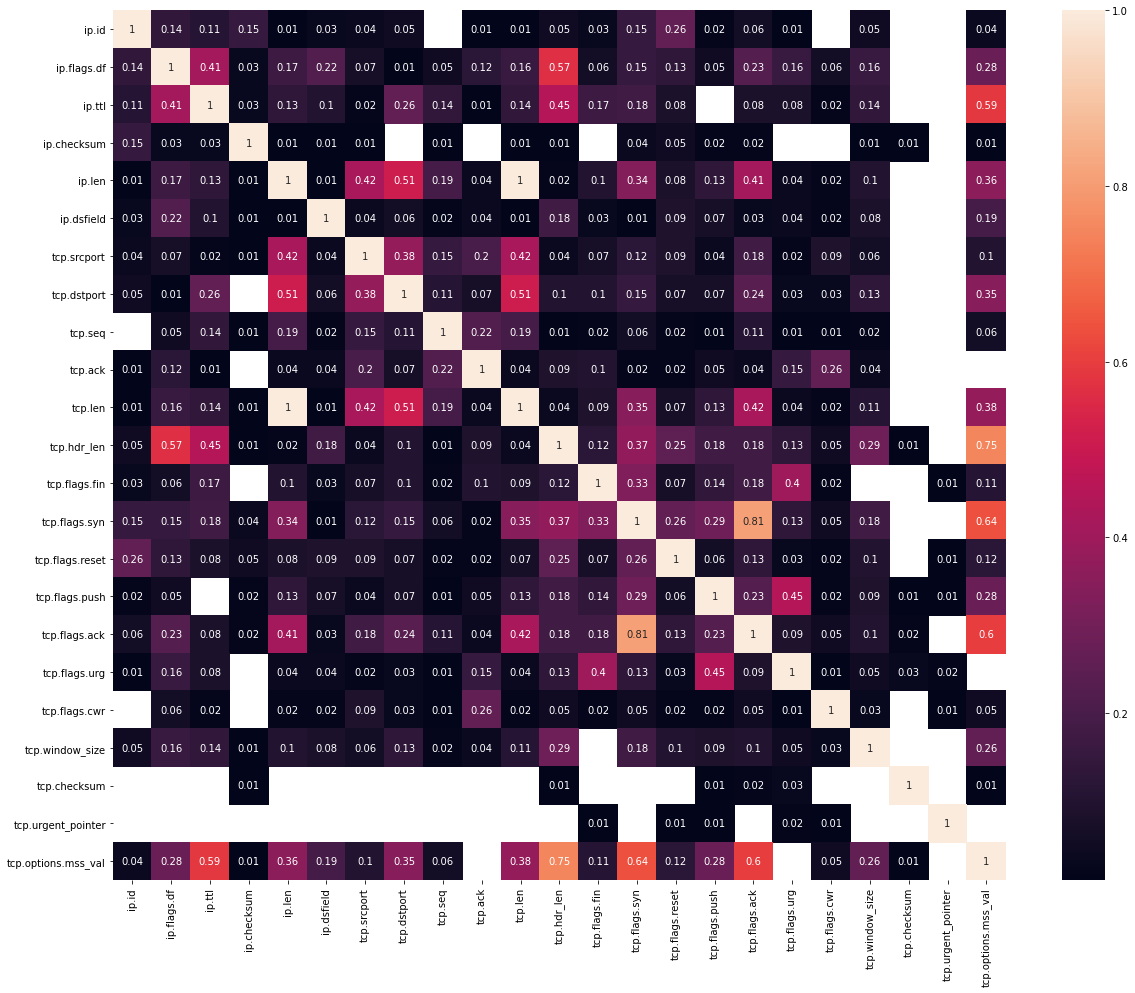

In [20]:
import seaborn as sns
high_corr = full_data.corr().abs().round(2)
high_corr_var = high_corr[high_corr>0]
plt.figure(figsize = (20,16))
sns.heatmap(high_corr_var, xticklabels=high_corr_var.columns, yticklabels=high_corr_var.columns, annot=True);

---
## Machine Learning - Binary Classification _(attack x bonafide)_

In [21]:
full_data['label'].value_counts()

bonafide         328261
zmap              74613
nmap_connect      45882
hping_syn         43750
unicorn_syn       43039
nmap_syn          40642
unicorn_conn      39170
masscan           21138
nmap_ack          20497
nmap_window       18851
nmap_null         12511
nmap_xmas         12505
nmap_fin          12504
hping_ack         11344
nmap_maimon       10493
unicorn_ack        8494
hping_null         7344
hping_xmas         7344
hping_fin          7344
unicorn_null       4690
unicorn_xmas       4466
unicorn_fxmas      4444
unicorn_fin        4438
Name: label, dtype: int64

In [22]:
full_data.label[full_data.label == "bonafide"] = 0 # replace "normal" labels to 0
full_data.label[full_data.label != 0] = 1 # replace all scan labels to 1
full_data['label'].value_counts()

1    455503
0    328261
Name: label, dtype: int64

In [23]:
full_data.shape

(783764, 24)

### Remove more columns
>
> - checksum and acknowlegde are random
> - tcp.dstport will tend to learn the testbed (some tools were targeted to specific services)

In [24]:
full_data.drop(columns=["ip.checksum", "tcp.checksum", 
                        "tcp.ack", "tcp.dstport"], axis=1, inplace=True)
#  "tcp.options.mss_val" , "tcp.seq", "tcp.srcport",

In [25]:
full_data

,ip.id,ip.flags.df,ip.ttl,ip.len,ip.dsfield,tcp.srcport,tcp.seq,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer,tcp.options.mss_val,label
1,46834,0.0,247.0,40.0,0,53026.0,0.0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,0.0,0
3,3793,1.0,56.0,537.0,8,443.0,1.0,485.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,252.0,0.0,0.0,0
4,0,1.0,59.0,80.0,0,59206.0,1.0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4677.0,0.0,0.0,0
5,8559,1.0,55.0,54.0,0,52239.0,1.0,2.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,115.0,0.0,0.0,0
6,54321,0.0,244.0,40.0,8,44034.0,0.0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65535.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455498,26910,1.0,28.0,60.0,0,35408.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,64240.0,0.0,1440.0,1
455499,45092,1.0,32.0,60.0,0,44454.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,64240.0,0.0,1440.0,1
455500,4058,1.0,28.0,60.0,0,58236.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,64240.0,0.0,1440.0,1
455501,1422,1.0,32.0,60.0,0,59870.0,0.0,0.0,40.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,64240.0,0.0,1440.0,1


In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

algorithms = {
    "MLP" : (MLPClassifier(), {
        "hidden_layer_sizes" : (10, 10),
    }),
    "SVM" : (SVC(), {
        "C" : [1, 10],
        "kernel" : ("linear", "rbf")
    }),
    "KNN" : (KNeighborsClassifier(), {
        "n_neighbors" : [1, 3, 5]
    }),
    "XGB" : (XGBClassifier(), {}),
    "NB" : (GaussianNB(), {}),
    "LR" : (LogisticRegression(), {}),
    "RF" : (RandomForestClassifier(random_state=17), {
        "n_estimators" : [10, 15, 20],
        "criterion" : ("gini", "entropy"), 
        "max_depth": [5, 10],
        "class_weight": (None, "balanced", "balanced_subsample")
    }),
    "DT" : (DecisionTreeClassifier(), {
        "criterion": ("gini", "entropy"), 
        "max_depth": [5, 10, 15],
        "class_weight": (None, "balanced")
    }),
}

full_data = full_data.fillna(0)
X = full_data.drop(columns = ["label"])
y = full_data.label

print(X.shape, y.shape)

(783764, 19) (783764,)


In [27]:
X.head()

,ip.id,ip.flags.df,ip.ttl,ip.len,ip.dsfield,tcp.srcport,tcp.seq,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer,tcp.options.mss_val
1,46834,0.0,247.0,40.0,0,53026.0,0.0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1024.0,0.0,0.0
3,3793,1.0,56.0,537.0,8,443.0,1.0,485.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,252.0,0.0,0.0
4,0,1.0,59.0,80.0,0,59206.0,1.0,0.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4677.0,0.0,0.0
5,8559,1.0,55.0,54.0,0,52239.0,1.0,2.0,32.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,115.0,0.0,0.0
6,54321,0.0,244.0,40.0,8,44034.0,0.0,0.0,20.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,65535.0,0.0,0.0


In [28]:
X = X.astype(int) 
X.head()

,ip.id,ip.flags.df,ip.ttl,ip.len,ip.dsfield,tcp.srcport,tcp.seq,tcp.len,tcp.hdr_len,tcp.flags.fin,tcp.flags.syn,tcp.flags.reset,tcp.flags.push,tcp.flags.ack,tcp.flags.urg,tcp.flags.cwr,tcp.window_size,tcp.urgent_pointer,tcp.options.mss_val
1,46834,0,247,40,0,53026,0,0,20,0,1,0,0,0,0,0,1024,0,0
3,3793,1,56,537,8,443,1,485,32,0,0,0,1,1,0,0,252,0,0
4,0,1,59,80,0,59206,1,0,60,0,0,0,0,1,0,0,4677,0,0
5,8559,1,55,54,0,52239,1,2,32,0,0,0,1,1,0,0,115,0,0
6,54321,0,244,40,8,44034,0,0,20,0,1,0,0,0,0,0,65535,0,0


## Grid Search for Machine Learning Algorithms

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, roc_auc_score

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17) # Train, Test
gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17) # Validation
perf = f1_score # pode ser considerado também o roc_auc_score na classificação binária

score = {}
for algorithm in algorithms.keys():
    score[algorithm] = []

for algorithm, (clf, parameters) in algorithms.items():
    print(algorithm)
    for train, test in kf.split(X, y):
        prep = StandardScaler()
        #prep = MinMaxScaler()
        prep.fit(X.iloc[train])
        best = GridSearchCV(clf, parameters, cv=gskf, scoring=make_scorer(perf))
        best.fit(prep.transform(X.iloc[train]), y.iloc[train])
        score[algorithm].append(perf(best.predict(prep.transform(X.iloc[test])), y.iloc[test]))

MLP
SVM


In [ ]:
# f1-scores para o melhor conjunto de parâmetros do Grid Search
pd.DataFrame.from_dict(score)

---

## Grid-search results
> Hyper-parameters, mean and stddev